# OneStopEnglish: Exploratory Data Analysis

In [1]:
# Import packages
import numpy as np
import pandas as pd
import spacy
import re
import textstat
import os
from os import listdir
from os.path import join, isfile
import chardet

In [2]:
# Sets option to display all text in pandas dataframes
pd.set_option('display.max_colwidth', None)

In [89]:
# Get file path for OneStopEnglish Corpus from individual TXT files.
FilePath = os.getcwd() + '/OneStopEng/TextByReadingLevel/'

# For some reason there are two "Int" files--do not import the first, as there 
SubDir = [join(FilePath, f)+'/' for f in listdir(FilePath) if f != 'Int-Txt']

# Load all texts into pandas data frame
TextDF = pd.DataFrame()

for s in SubDir:
    TextFiles = listdir(s)

    for t in TextFiles:
        # There is a hidden .ds_store file that should be skipped when importing data
        if t == '.DS_Store':
            pass
        else:
            file = open(s + t, 'r')
            text = file.read()
            file.close()

            TextDF = TextDF.append({'file_nm' : t,
                                    'text' : text},
                                   ignore_index = True)

In [90]:
# Isolate name and level of text and drop file_nm
TextDF['name'] = TextDF['file_nm'].str[:-8]
TextDF['level'] = TextDF['file_nm'].str[-7:-4]
TextDF['text'] = TextDF['text'].apply(str)

TextDF.groupby(['level'])['text'].count()

# Intermediate text is labeled--this should be removed
# TextDF['text'] = TextDF['text'].map(lambda x: x.lstrip('Intermediate'))
# TextDF['text'] = TextDF['text'].str.replace('\n', ' ')

level
adv    189
ele    189
int    189
Name: text, dtype: int64

In [91]:
# Compute text difficulty using textstat
TextDF['difficulty'] = TextDF['text'].apply(textstat.flesch_reading_ease)

# Compute different statistics for text entries
TextDF['n_sent'] = TextDF['text'].apply(textstat.sentence_count)
TextDF['n_syll'] = TextDF['text'].apply(textstat.syllable_count)
TextDF['n_lex'] = TextDF['text'].apply(textstat.lexicon_count)
TextDF['syll_sent'] = TextDF['n_syll']/TextDF['n_sent']

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: difficulty, dtype: object

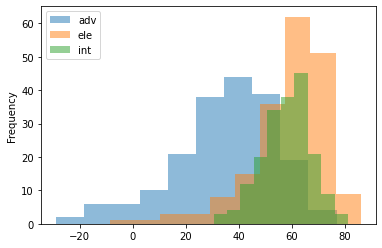

In [101]:
TextDF.groupby('level')['difficulty'].plot(kind = 'hist', legend = True, alpha = 0.5)

# Basic ML Models

In [93]:
# Set seed so results can be reproduced
randomseed = 20200922

In [136]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [123]:
# Preprocess data

# Label encoder
le = preprocessing.LabelEncoder()

# Subset TextDF to desired variables
MLDat = TextDF[['level', 'difficulty', 'n_sent', 'n_syll', 'n_lex']].reset_index().drop(columns = ['index'])
MLDat['level'] = le.fit_transform(MLDat['level'])

# Target and predictor variables
y = MLDat['level']
X = MLDat[['difficulty', 'n_sent', 'n_syll', 'n_lex']]

# Split data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = randomseed)

In [132]:
# Gaussian Naive Bayes Model
gnb = GaussianNB()
pred = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, pred, normalize = True)

0.7192982456140351

In [135]:
# Linear support verctor classification
svc = LinearSVC(random_state = randomseed)
pred = svc.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, pred, normalize = True)

/anaconda3/envs/InsightDS/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5789473684210527

In [137]:
# K neighbors classifier
knc = KNeighborsClassifier(n_neighbors = 3)
knc.fit(X_train, y_train)
pred = knc.predict(X_test)
accuracy_score(y_test, pred, normalize = True)

0.6754385964912281

In [10]:
###################################
# IMPORT DATA STORED IN CSV FILES #
###################################

# Get file path to OneStopEnglish Corpus including combined CSV files.
FilePath = os.getcwd() + '/OneStopEng/TextOneCSVPerFile/'

# Texts are organized by difficulty level
Files = listdir(FilePath)

# Import all texts into pandas dataframe
oseDF = pd.DataFrame() # Initialize dataframe

# Loop through all files
for f in Files:
    
    # Files have different encodings
    # Find the encoding for each file and use that in read_csv command
    with open(FilePath + f, 'rb') as rawdat:
        result = chardet.detect(rawdat.read(10000))
        
    oseDFA = pd.read_csv(FilePath + f, encoding = result['encoding'])
    oseDFA['name'] = f
    
    oseDF = oseDF.append(oseDFA)